# Setup Notebook

In [1]:
import warnings
warnings.simplefilter('ignore')

# To load data
import zipfile
import numpy as np
import pandas as pd

# For text processing
import re
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import Imputer
from scipy import sparse
from sklearn.model_selection import train_test_split

# To build model
import keras
from keras.layers import Dense, concatenate, Input, Dropout, Embedding, Flatten, Bidirectional, GRU, Conv1D, MaxPooling1D
from keras.models import Model

# To train model
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint

# To evaluate model
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

# To track time elapsed
import time

# To save results
import dill
import json
import pickle

Using TensorFlow backend.


# Load Data

In [2]:
def load_data():
    """
    Return pandas dataframe data_train: training data (features + labels)
    Return pandas dataframe data_test: test data (only features)
    
    Required Libraries: zipfile, pandas
    """
    
    # Load zipped folder with data files
    resource_archive = zipfile.ZipFile('resources.zip', 'r')

    # Load testing data
    data_test = pd.read_csv(resource_archive.open('TestData.csv'), 
                            dtype={
                                'Object_Description': str, 
                                'Program_Description': str, 
                                'SubFund_Description': str, 
                                'Job_Title_Description': str, 
                                'Facility_or_Department': str,
                                'Sub_Object_Description': str, 
                                'Location_Description': str, 
                                'FTE': float,
                                'Function_Description': str, 
                                'Position_Extra': str, 
                                'Text_4': str, 
                                'Total': float, 
                                'Text_2': str,
                                'Text_3': str, 
                                'Fund_Description': str, 
                                'Text_1': str
                            },
                            index_col=0)

    # Load training data
    data_train = pd.read_csv(resource_archive.open('TrainingData.csv'), 
                            dtype={
                                'Object_Description': str, 
                                'Program_Description': str, 
                                'SubFund_Description': str, 
                                'Job_Title_Description': str, 
                                'Facility_or_Department': str,
                                'Sub_Object_Description': str, 
                                'Location_Description': str, 
                                'FTE': float,
                                'Function_Description': str, 
                                'Position_Extra': str, 
                                'Text_4': str, 
                                'Total': float, 
                                'Text_2': str,
                                'Text_3': str, 
                                'Fund_Description': str, 
                                'Text_1': str,
                                'Function': 'category',
                                'Object_Type': 'category',
                                'Operating_Status': 'category',
                                'Position_Type': 'category',
                                'Pre_K': 'category',
                                'Reporting': 'category',
                                'Sharing': 'category',
                                'Student_Type': 'category',
                                'Use': 'category',
                            },
                             index_col=0)
    
    return data_train, data_test

In [3]:
data_train, data_test = load_data()
print('data_train shape:', data_train.shape)
print('data_test shape:', data_test.shape)

data_train shape: (400277, 25)
data_test shape: (50064, 16)


In [4]:
def load_features(data_train, data_test):
    """
    Return pandas dataframe data_features: data in feature columns of data_train and data_test
    
    Param pandas dataframe data_train: training data (features + labels)
    Param pandas dataframe data_test: test data (only features)
    
    Required Libraries: pandas
    """
    
    feature_columns = data_test.columns # data_test only contains features
    
    data_features = pd.concat([data_train[feature_columns], data_test])
    
    return data_features

In [5]:
# Load Features
data_features = load_features(data_train, data_test)
print('data_features shape:', data_features.shape)

data_features shape: (450341, 16)


# Prepare Data for Classification
Run the cells below if prepped data files have not been created

In [ ]:
def text_processing(phrase):
    """
    Return list processed_phrase: phrase tokens after processing has been completed
    
    param string phrase: phrase to be processed
    
    Required Libraries: re, nltk
    """
    
    # Case Normalization
    processed_phrase = phrase.lower()
    
    # Remove Punctuations
    processed_phrase = re.sub(r"[^a-z0-9-]", " ", processed_phrase)
    
    # Tokenize Phrase
    processed_phrase = processed_phrase.split()
    
    # Remove Stopwords
    processed_phrase = [word for word in processed_phrase if word not in stopwords.words("english") and word != '-']
    
    # Lemmatization
    processed_phrase = [WordNetLemmatizer().lemmatize(word) for word in processed_phrase]
    
    # Recombine list into phrase
    processed_phrase = ' '.join(processed_phrase)
    
    return processed_phrase

In [ ]:
# test text_processing function (with quote from Hamilton: The Musical)
start_time = time.time()
print(text_processing(
    "I’m past patiently waitin’. I’m passionately smashin’ every expectation. " + 
    "Every action’s an act of creation! " +
    "I’m laughin’ in the face of casualties and sorrow. " +
    "For the first time, I’m thinkin’ past tomorrow"))
print(time.time() - start_time)

past patiently waitin passionately smashin every expectation every action act creation laughin face casualty sorrow first time thinkin past tomorrow
2.5811121463775635


In [ ]:
def init_prep(data_train, data_test, data_features, label=None):
    """
    Return numpy array X_numeric: numerical feature matrix of test set
    Return numpy array X_text: text feature matrix for classification model fitting
    Return numpy array X_numeric_test: numerical feature matrix of test set
    Return numpy array X_text_test: text feature matrix for classification model fitting
    Return numpy array y: labels matrix for classification model fitting
    Return keras.Tokenizer() tokenize: contains word to token mapping
    
    Param pandas dataframe data_train: training data (features + labels)
    Param pandas dataframe data_test: test data (features)
    Param pandas dataframe data_features: data in feature columns of data_train and data_test
    
    Required Libraries: pandas, numpy, keras
    Required helper functions: text_processing
    """
    
    # Combined and preprocess text columns
    data_train['combined_text'] = (data_train[data_features.columns]
                                       .drop(columns=['FTE', 'Total'])
                                       .fillna("")
                                       .apply(lambda x: " ".join(x), axis=1)
                                       .apply(lambda x: text_processing(x))
                                  )
    data_test['combined_text'] = (data_test[data_features.columns]
                                       .drop(columns=['FTE', 'Total'])
                                       .fillna("")
                                       .apply(lambda x: " ".join(x), axis=1)
                                       .apply(lambda x: text_processing(x))
                                 )
    data_features['combined_text'] = (data_features
                                          .drop(columns=['FTE', 'Total'])
                                          .fillna("")
                                          .apply(lambda x: " ".join(x), axis=1)
                                          .apply(lambda x: text_processing(x))
                                     )
    
    # Vectorizer text columns in training data
    tokenize = Tokenizer()
    tokenize.fit_on_texts(data_features['combined_text'])
    
    X_text = tokenize.texts_to_sequences(data_train['combined_text'])
    X_text_test = tokenize.texts_to_sequences(data_test['combined_text'])
    
    X_text = pad_sequences(X_text, padding='post', maxlen=50, truncating='post')
    X_text_test = pad_sequences(X_text_test, padding='post', maxlen=50, truncating='post')
    
    # Impute missing numerical data
    imp_total = Imputer(strategy='median')
    imp_total.fit(data_features['Total'].values.reshape(-1, 1))

    total_not_missing = pd.isnull(data_train['Total']).astype(int).values.reshape(-1, 1)
    fte_not_missing = pd.isnull(data_train['FTE']).astype(int).values.reshape(-1, 1)
    total = imp_total.transform(data_train['Total'].values.reshape(-1, 1))
    fte = data_train['FTE'].fillna('0').values.reshape(-1, 1)

    total_not_missing_test = pd.isnull(data_test['Total']).astype(int).values.reshape(-1, 1)
    fte_not_missing_test = pd.isnull(data_test['FTE']).astype(int).values.reshape(-1, 1)
    total_test = imp_total.transform(data_test['Total'].values.reshape(-1, 1))
    fte_test = data_test['FTE'].fillna('0').values.reshape(-1, 1)
    
    # Create feature matrix
    X_numeric = np.concatenate([total, total_not_missing, fte, fte_not_missing], axis=1)
    X_numeric_test = np.concatenate([total_test, total_not_missing_test, fte_test, fte_not_missing_test], axis=1)
    
    # Create labels matrix
    if label:
        y = pd.get_dummies(data_train[label]).values.astype('float64')
    else:
        label = ['Function',
                 'Object_Type',
                 'Operating_Status',
                 'Position_Type',
                 'Pre_K',
                 'Reporting',
                 'Sharing',
                 'Student_Type',
                 'Use']
        y = pd.get_dummies(data_train[label]).values.astype('float64')
    
    return X_numeric, X_text, X_numeric_test, X_text_test, y, tokenize

In [ ]:
X_numeric, X_text, X_test_numeric, X_test_text, y, tokenize = init_prep(data_train, data_test, data_features)

In [ ]:
# Save X_test_text and X_test_numeric
np.savez('X_test_text.npz', X_test_text)
np.savez('X_test_numeric.npz', X_test_numeric)

# Pickle tokenize
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def prep_for_classification(X_numeric, X_text, y, validation_size=50064):
    """
    Split training data into training and validation sets
    
    Return pandas dataframe X_train_numeric: training data (features)
    Return pandas dataframe X_train_text: training data (features)
    Return pandas dataframe X_val_numeric: validation data (features)
    Return pandas dataframe X_val_text: validation data (features)
    Return pandas dataframe y_train: training data (labels)
    Return pandas dataframe y_val: validation data (labels)
    
    param numpy array X_numeric: numerical feature matrix of test set
    param numpy array X_text: text feature matrix for classification model fitting
    param numpy array X_numeric_test: numerical feature matrix of test set
    param numpy array X_text_test: text feature matrix for classification model fitting
    param numpy array y: labels matrix for classification model fitting
    
    Required Libraries: pandas, sklearn.model_selection
    """
    
    # Split into training and development sets
    X_train_numeric, X_val_numeric, X_train_text, X_val_text, y_train, y_val = train_test_split(X_numeric, X_text, y, test_size=validation_size, random_state=93)
    
    return X_train_numeric, X_val_numeric, X_train_text, X_val_text, y_train, y_val

In [ ]:
X_train_numeric, X_val_numeric, X_train_text, X_val_text, y_train, y_val = prep_for_classification(X_numeric, X_text, y)
print('X_train_numeric', X_train_numeric.shape)
print('X_train_text', X_train_text.shape)
print('y_train', y_train.shape)
print('X_val_numeric', X_val_numeric.shape)
print('X_val_text', X_val_text.shape)
print('y_val', y_val.shape)

X_train_numeric (350213, 4)
X_train_text (350213, 50)
y_train (350213, 104)
X_val_numeric (50064, 4)
X_val_text (50064, 50)
y_val (50064, 104)


In [ ]:
# Save prepped data
y_train = sparse.csr_matrix(y_train)
y_val = sparse.csr_matrix(y_val)

np.savez('X_train_text.npz', X_train_text)
np.savez('X_val_text.npz', X_val_text)
np.savez('X_train_numeric.npz', X_train_numeric)
np.savez('X_val_numeric.npz', X_val_numeric)
sparse.save_npz('y_train.npz', y_train)
sparse.save_npz('y_val.npz', y_val)

# Load Prepped Data
Run these cells below if prepped data files are available.

In [6]:
X_train_text = np.load('X_train_text.npz')['arr_0']
X_val_text = np.load('X_val_text.npz')['arr_0']
X_train_numeric = np.load('X_train_numeric.npz')['arr_0']
X_val_numeric = np.load('X_val_numeric.npz')['arr_0']
y_train = sparse.load_npz('y_train.npz')
y_val = sparse.load_npz('y_val.npz')
X_test_numeric = np.load('X_test_numeric.npz')['arr_0']
X_test_text = np.load('X_test_text.npz')['arr_0']

print('X_train_numeric', X_train_numeric.shape)
print('X_train_text', X_train_text.shape)
print('y_train', y_train.shape)
print('X_val_numeric', X_val_numeric.shape)
print('X_val_text', X_val_text.shape)
print('y_val', y_val.shape)
print('X_test_numeric', X_test_numeric.shape)
print('X_test_text', X_test_text.shape)

X_train_numeric (350213, 4)
X_train_text (350213, 50)
y_train (350213, 104)
X_val_numeric (50064, 4)
X_val_text (50064, 50)
y_val (50064, 104)
X_test_numeric (50064, 4)
X_test_text (50064, 50)


# Build Model
Run cells below if model has not been fitted yet

In [ ]:
def build_network(X_numeric=X_train_numeric, X_text=X_train_text, y=y_train):
    """
    Return compiled keras-model model
    
    param numpy array X: feature matrix for classification
    param numpy array y: labels matrix for classification
    
    Required Libraries: keras
    """
    
    dropout_value = 0.5
    embedding_vector_length = 8
    kernel_size_value = 8
    padding_value = 'same'
    stride_value = 2
    pool_size_value = 2
    
    numeric_input = Input(shape=(X_numeric.shape[1],) , name='numeric_input') 
    text_input = Input(shape=(X_text.shape[1],) , name='text_input')
    
    # Function
    word_embedding_function = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_function_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_function)
    text_function_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_function_hidden_layer)
    text_function_hidden_layer = Dropout(dropout_value)(text_function_hidden_layer)
    text_function_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_function_hidden_layer)
    text_function_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_function_hidden_layer)
    text_function_hidden_layer = Dropout(dropout_value)(text_function_hidden_layer)
    text_function_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_function_hidden_layer)
    text_function_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_function_hidden_layer)
    text_function_hidden_layer = Dropout(dropout_value)(text_function_hidden_layer)
    dense_function_layer = Flatten()(text_function_hidden_layer)
    dense_function_layer = Dense(64, activation='relu')(dense_function_layer)
    numeric_function_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_function_hidden_layer = Dropout(dropout_value)(numeric_function_hidden_layer)
    combined_function_layer = concatenate([numeric_function_hidden_layer, dense_function_layer])
    function_output_layer = Dense(37, activation='softmax')(combined_function_layer)
    
    # Object_Type
    word_embedding_object_type = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_object_type_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_object_type)
    text_object_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Dropout(dropout_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_object_type_hidden_layer)
    text_object_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Dropout(dropout_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_object_type_hidden_layer)
    text_object_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Dropout(dropout_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_object_type_hidden_layer)
    text_object_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Dropout(dropout_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Conv1D(16, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_object_type_hidden_layer)
    text_object_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_object_type_hidden_layer)
    text_object_type_hidden_layer = Dropout(dropout_value)(text_object_type_hidden_layer)
    dense_object_type_layer = Flatten()(text_object_type_hidden_layer)
    dense_object_type_layer = Dense(16, activation='relu')(dense_object_type_layer)
    numeric_object_type_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_object_type_hidden_layer = Dropout(dropout_value)(numeric_object_type_hidden_layer)
    combined_object_type_layer = concatenate([numeric_object_type_hidden_layer, dense_object_type_layer])
    object_type_output_layer = Dense(11, activation='softmax')(combined_object_type_layer)
    
    # Operating_Status
    word_embedding_operating_status = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_operating_status_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_operating_status)
    text_operating_status_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Dropout(dropout_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Dropout(dropout_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Dropout(dropout_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Dropout(dropout_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Conv1D(16, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Dropout(dropout_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Conv1D(8, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Dropout(dropout_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Conv1D(4, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_operating_status_hidden_layer)
    text_operating_status_hidden_layer = Dropout(dropout_value)(text_operating_status_hidden_layer)
    dense_operating_status_layer = Flatten()(text_operating_status_hidden_layer)
    dense_operating_status_layer = Dense(4, activation='relu')(dense_operating_status_layer)
    numeric_operating_status_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_operating_status_hidden_layer = Dropout(dropout_value)(numeric_operating_status_hidden_layer)
    combined_operating_status_layer = concatenate([numeric_operating_status_hidden_layer, dense_operating_status_layer])
    operating_status_output_layer = Dense(3, activation='softmax')(combined_operating_status_layer)
    
    # Position_Type
    word_embedding_position_type = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_position_type_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_position_type)
    text_position_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_position_type_hidden_layer)
    text_position_type_hidden_layer = Dropout(dropout_value)(text_position_type_hidden_layer)
    text_position_type_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_position_type_hidden_layer)
    text_position_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_position_type_hidden_layer)
    text_position_type_hidden_layer = Dropout(dropout_value)(text_position_type_hidden_layer)
    text_position_type_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_position_type_hidden_layer)
    text_position_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_position_type_hidden_layer)
    text_position_type_hidden_layer = Dropout(dropout_value)(text_position_type_hidden_layer)
    text_position_type_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_position_type_hidden_layer)
    text_position_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_position_type_hidden_layer)
    text_position_type_hidden_layer = Dropout(dropout_value)(text_position_type_hidden_layer)
    dense_position_type_layer = Flatten()(text_position_type_hidden_layer)
    dense_position_type_layer = Dense(32, activation='relu')(dense_position_type_layer)
    numeric_position_type_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_position_type_hidden_layer = Dropout(dropout_value)(numeric_position_type_hidden_layer)
    combined_position_type_layer = concatenate([numeric_position_type_hidden_layer, dense_position_type_layer])
    position_type_output_layer = Dense(25, activation='softmax')(combined_position_type_layer)
    
    # Pre_K
    word_embedding_pre_k = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_pre_k_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_pre_k)
    text_pre_k_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Dropout(dropout_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Dropout(dropout_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Dropout(dropout_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Dropout(dropout_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Conv1D(16, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Dropout(dropout_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Conv1D(8, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Dropout(dropout_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Conv1D(4, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_pre_k_hidden_layer)
    text_pre_k_hidden_layer = Dropout(dropout_value)(text_pre_k_hidden_layer)
    dense_pre_k_layer = Flatten()(text_pre_k_hidden_layer)
    dense_pre_k_layer = Dense(4, activation='relu')(dense_pre_k_layer)
    numeric_pre_k_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_pre_k_hidden_layer = Dropout(dropout_value)(numeric_pre_k_hidden_layer)
    combined_pre_k_layer = concatenate([numeric_pre_k_hidden_layer, dense_pre_k_layer])
    pre_k_output_layer = Dense(3, activation='softmax')(combined_pre_k_layer)
    
    # Reporting
    word_embedding_reporting = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_reporting_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_reporting)
    text_reporting_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Dropout(dropout_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_reporting_hidden_layer)
    text_reporting_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Dropout(dropout_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_reporting_hidden_layer)
    text_reporting_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Dropout(dropout_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_reporting_hidden_layer)
    text_reporting_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Dropout(dropout_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Conv1D(16, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_reporting_hidden_layer)
    text_reporting_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Dropout(dropout_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Conv1D(8, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_reporting_hidden_layer)
    text_reporting_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Dropout(dropout_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Conv1D(4, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_reporting_hidden_layer)
    text_reporting_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_reporting_hidden_layer)
    text_reporting_hidden_layer = Dropout(dropout_value)(text_reporting_hidden_layer)
    dense_reporting_layer = Flatten()(text_pre_k_hidden_layer)
    dense_reporting_layer = Dense(4, activation='relu')(dense_reporting_layer)
    numeric_reporting_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_reporting_hidden_layer = Dropout(dropout_value)(numeric_reporting_hidden_layer)
    combined_reporting_layer = concatenate([numeric_reporting_hidden_layer, dense_reporting_layer])
    reporting_output_layer = Dense(3, activation='softmax')(combined_reporting_layer)
    
    # Sharing
    word_embedding_sharing = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_sharing_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_sharing)
    text_sharing_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Dropout(dropout_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_sharing_hidden_layer)
    text_sharing_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Dropout(dropout_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_sharing_hidden_layer)
    text_sharing_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Dropout(dropout_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_sharing_hidden_layer)
    text_sharing_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Dropout(dropout_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Conv1D(16, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_sharing_hidden_layer)
    text_sharing_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Dropout(dropout_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Conv1D(8, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_sharing_hidden_layer)
    text_sharing_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_sharing_hidden_layer)
    text_sharing_hidden_layer = Dropout(dropout_value)(text_sharing_hidden_layer)
    dense_sharing_layer = Flatten()(text_sharing_hidden_layer)
    dense_sharing_layer = Dense(8, activation='relu')(dense_sharing_layer)
    numeric_sharing_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_sharing_hidden_layer = Dropout(dropout_value)(numeric_sharing_hidden_layer)
    combined_sharing_layer = concatenate([numeric_sharing_hidden_layer, dense_sharing_layer])
    sharing_output_layer = Dense(5, activation='softmax')(combined_sharing_layer)
    
    # Student_Type
    word_embedding_student_type = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_student_type_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_student_type)
    text_student_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Dropout(dropout_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_student_type_hidden_layer)
    text_student_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Dropout(dropout_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_student_type_hidden_layer)
    text_student_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Dropout(dropout_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_student_type_hidden_layer)
    text_student_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Dropout(dropout_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Conv1D(16, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_student_type_hidden_layer)
    text_student_type_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_student_type_hidden_layer)
    text_student_type_hidden_layer = Dropout(dropout_value)(text_student_type_hidden_layer)
    dense_student_type_layer = Flatten()(text_student_type_hidden_layer)
    dense_student_type_layer = Dense(16, activation='relu')(dense_student_type_layer)
    numeric_student_type_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_student_type_hidden_layer = Dropout(dropout_value)(numeric_student_type_hidden_layer)
    combined_student_type_layer = concatenate([numeric_student_type_hidden_layer, dense_student_type_layer])
    student_type_output_layer = Dense(9, activation='softmax')(combined_student_type_layer)
    
    # Use
    word_embedding_use = Embedding(input_dim=3804, output_dim=embedding_vector_length, mask_zero=False, input_length=50)(text_input)
    text_use_hidden_layer = Conv1D(256, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(word_embedding_use)
    text_use_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_use_hidden_layer)
    text_use_hidden_layer = Dropout(dropout_value)(text_use_hidden_layer)
    text_use_hidden_layer = Conv1D(128, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_use_hidden_layer)
    text_use_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_use_hidden_layer)
    text_use_hidden_layer = Dropout(dropout_value)(text_use_hidden_layer)
    text_use_hidden_layer = Conv1D(64, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_use_hidden_layer)
    text_use_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_use_hidden_layer)
    text_use_hidden_layer = Dropout(dropout_value)(text_use_hidden_layer)
    text_use_hidden_layer = Conv1D(32, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_use_hidden_layer)
    text_use_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_use_hidden_layer)
    text_use_hidden_layer = Dropout(dropout_value)(text_use_hidden_layer)
    text_use_hidden_layer = Conv1D(16, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_use_hidden_layer)
    text_use_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_use_hidden_layer)
    text_use_hidden_layer = Dropout(dropout_value)(text_use_hidden_layer)
    text_use_hidden_layer = Conv1D(8, kernel_size=kernel_size_value, padding=padding_value, strides=stride_value, activation='relu')(text_use_hidden_layer)
    text_use_hidden_layer = MaxPooling1D(pool_size=pool_size_value, padding=padding_value, strides=stride_value)(text_use_hidden_layer)
    text_use_hidden_layer = Dropout(dropout_value)(text_use_hidden_layer)
    dense_use_layer = Flatten()(text_use_hidden_layer)
    dense_use_layer = Dense(8, activation='relu')(dense_use_layer)
    numeric_use_hidden_layer = Dense(4, activation='relu')(numeric_input)
    numeric_use_hidden_layer = Dropout(dropout_value)(numeric_use_hidden_layer)
    combined_use_layer = concatenate([numeric_use_hidden_layer, dense_use_layer])
    use_output_layer = Dense(8, activation='softmax')(combined_use_layer)
    
    # Output
    combined_output_layer = concatenate([function_output_layer, 
                                         object_type_output_layer,
                                         operating_status_output_layer,
                                         position_type_output_layer,
                                         pre_k_output_layer,
                                         reporting_output_layer,
                                         sharing_output_layer,
                                         student_type_output_layer,
                                         use_output_layer])
    
    model = Model(inputs=[numeric_input, text_input], outputs=[combined_output_layer])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
cnn_NN = build_network()

# Save model architecture
model_json = cnn_NN.to_json()
with open('cnn_NN_model.json', 'w') as json_file:
    json_file.write(model_json)

# Train model and generate predictions on test set

In [10]:
early_stopping_monitor = EarlyStopping(patience=10)
checkpointer = ModelCheckpoint(filepath="cnn_NN_model.h5", verbose=1, save_best_only=True)

history_cnn_NN = cnn_NN.fit([X_train_numeric, X_train_text], y_train, epochs=100, batch_size=2048, validation_split=0.1, callbacks=[early_stopping_monitor, checkpointer])

Train on 315191 samples, validate on 35022 samples
Epoch 1/100
315191/315191 [==============================] - 179s 569us/step - loss: 68.7306 - acc: 0.0252 - val_loss: 61.7684 - val_acc: 0.0563

Epoch 00001: val_loss improved from inf to 61.76838, saving model to drive/cnn_NN_model.h5
Epoch 2/100
315191/315191 [==============================] - 171s 541us/step - loss: 49.5048 - acc: 0.1147 - val_loss: 50.5769 - val_acc: 0.1872

Epoch 00002: val_loss improved from 61.76838 to 50.57688, saving model to drive/cnn_NN_model.h5
Epoch 3/100
315191/315191 [==============================] - 171s 542us/step - loss: 41.2320 - acc: 0.1683 - val_loss: 36.3888 - val_acc: 0.1936

Epoch 00003: val_loss improved from 50.57688 to 36.38877, saving model to drive/cnn_NN_model.h5
Epoch 4/100
315191/315191 [==============================] - 171s 543us/step - loss: 35.2857 - acc: 0.1882 - val_loss: 33.4225 - val_acc: 0.1951

Epoch 00004: val_loss improved from 36.38877 to 33.42253, saving model to drive/cn

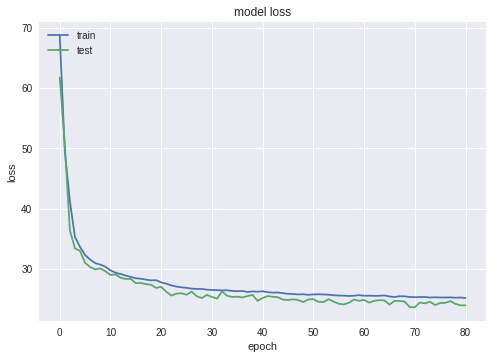

In [11]:
plt.plot(history_cnn_NN.history['loss'])
plt.plot(history_cnn_NN.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Load pre-trained model
Run cell below if model has already been trained, and json and h5 files are available

In [7]:
# load json and create model
with open('cnn_NN_model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    
cnn_NN = model_from_json(loaded_model_json)
cnn_NN.load_weights("cnn_NN_model.h5")

# Create predictions on test and validation sets

In [8]:
label_class_counts = {
    'Function': [0, 37], 
    'Object_Type': [37, 48], 
    'Operating_Status': [48, 51], 
    'Position_Type': [51, 76], 
    'Pre_K': [76, 79], 
    'Reporting': [79, 82], 
    'Sharing': [82, 87], 
    'Student_Type': [87, 96], 
    'Use': [96, 104]
}

scores = {}
val_predictions = cnn_NN.predict([X_val_numeric, X_val_text])

# Calculate validation logloss for each label
for label, indices in label_class_counts.items():
    # Get values for specific label
    start_idx = indices[0]
    end_idx = indices[1]
    y_val_label = y_val[:, start_idx:end_idx]
    val_predictions_label = val_predictions[:, start_idx:end_idx]
    
    
    # Get logloss score of mode
    scores[label] = log_loss(y_val_label, val_predictions_label)

In [9]:
# Generate predictions for test set
predictions = cnn_NN.predict([X_test_numeric, X_test_text])

# Save score and predictions

In [10]:
# Save predictions for test set
label = ['Function',
         'Object_Type',
         'Operating_Status',
         'Position_Type',
         'Pre_K',
         'Reporting',
         'Sharing',
         'Student_Type',
         'Use']
y = pd.get_dummies(data_train[label]).astype('float64')

submission = pd.DataFrame(predictions, index=data_test.index, columns=y.columns)
submission.to_csv('cnn_NN_model.csv')

In [11]:
scores

{'Function': 0.18381029245675215,
 'Object_Type': 0.1767483893181308,
 'Operating_Status': 0.44045025440946356,
 'Position_Type': 0.1440102000181701,
 'Pre_K': 0.30560131965580367,
 'Reporting': 0.5625786333094639,
 'Sharing': 0.23058234376702044,
 'Student_Type': 0.4918790614674071,
 'Use': 2.686110029018423}

In [12]:
np.mean([score for score in scores.values()])

0.5801967248245149

In [13]:
with open('cnn_NN_score.json', 'w') as file:
     file.write(json.dumps(scores))